<a href="https://colab.research.google.com/github/rakesh-sengupta/qrnn/blob/main/qRNN_RS_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
from scipy.integrate import solve_ivp
from scipy.linalg import eigvals
from itertools import combinations
from scipy.linalg import svd

# Define Pauli matrices
sigma_x = np.array([[0, 1], [1, 0]], dtype=complex)
sigma_z = np.array([[1, 0], [0, -1]], dtype=complex)

In [103]:
# Parameters for the quantum neural network
alpha = 2.0  # self-dynamics coefficient
beta = 0.1   # interaction coefficient
N = 4        # Number of qubits
hbar = 1.0   # Planck constant
U_F = 1.5    # Scaling factor for self-interaction terms
noise_strength = 0.01  # Magnitude of noise

In [106]:
# Define time-dependent input as a step function
def step_input(t, I_amplitude):
    return I_amplitude if t >= 2.0 else 0.0

In [107]:
# Construct the Hamiltonian
def H(t, I_amplitude):
    H = np.zeros((2**N, 2**N), dtype=complex)

    # Base self-energy term: -sum(sigma_z)
    for i in range(N):
        H -= np.kron(np.eye(2**i), np.kron(sigma_z, np.eye(2**(N-i-1))))

    # Self-dynamics with U_F, scaled by alpha
    for i in range(N):
        H += alpha * U_F * np.kron(np.eye(2**i), np.kron(sigma_z, np.eye(2**(N-i-1))))

    # Interaction terms between qubits (scaled by beta)
    for i in range(N):
        for j in range(i+1, N):
            interaction_term = np.kron(np.eye(2**i), np.kron(sigma_z, np.eye(2**(j-i-1))))
            interaction_term = np.kron(interaction_term, np.kron(sigma_z, np.eye(2**(N-j-1))))
            H -= beta * U_F * interaction_term

    # External input applied via Pauli-X (with step function input)
    for i in range(N):
        H_input = step_input(t, I_amplitude)
        H += H_input * np.kron(np.eye(2**i), np.kron(sigma_x, np.eye(2**(N-i-1))))

    # Noise term
    H += noise_strength * (np.random.rand(2**N, 2**N) - 0.5)

    return H


In [108]:
def time_evolution(t, psi_0, I_amplitude):
    def schrodinger_eq(t, psi_flat):
        psi = psi_flat.reshape((2**N, 1))
        H_t = H(t, I_amplitude)
        dpsi_dt = -1j / hbar * np.dot(H_t, psi)
        return dpsi_dt.flatten()

    sol = solve_ivp(schrodinger_eq, [0, t], psi_0.flatten(), t_eval=np.linspace(0, t, 100), method='RK45')
    return sol.t, sol.y  # Return time series


In [109]:
# Initial state (all qubits in |0> state)
psi_0 = np.zeros((2**N, 1), dtype=complex)
psi_0[0] = 1.0  # Initial state |000>

# Solve the time evolution for a specific input amplitude
I_amplitude = 2.0
t_final = 5.0
# Get the time evolution series
time, psi_t = time_evolution(t_final, psi_0, I_amplitude)
final_psi = time_evolution(t_final, psi_0, I_amplitude)

In [110]:
# Compute expectation values
def expectation_value(psi_t, sigma):
    exp_values = []
    for psi in psi_t.T:
        psi = psi.reshape((2**N, 1))
        exp_value = np.real(np.dot(psi.T.conj(), np.dot(np.kron(sigma, np.eye(2**(N-1))), psi)))
        exp_values.append(exp_value)
    return np.array(exp_values)

expect_z = expectation_value(psi_t, sigma_z).flatten()
expect_x = expectation_value(psi_t, sigma_x).flatten()

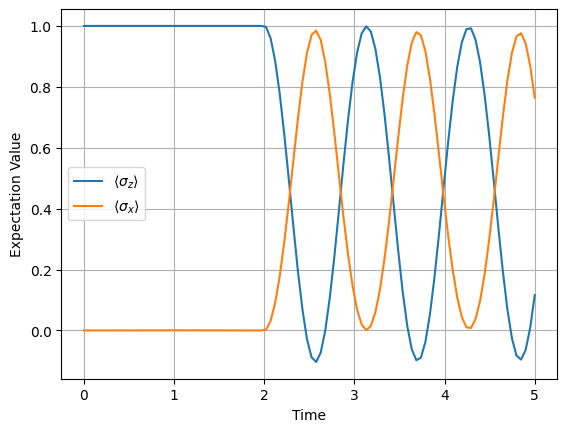

In [111]:
# Plot the expectation value over time
plt.plot(time, expect_z, label=r"$\langle \sigma_z \rangle$")
plt.plot(time, expect_x, label=r"$\langle \sigma_x \rangle$")
plt.xlabel("Time")
plt.ylabel("Expectation Value")
plt.legend()
plt.grid(True)
plt.show()

In [112]:
# 1. Quantum State Norm over Time
def plot_state_norm(time, psi_t):
    norms = [np.linalg.norm(psi)**2 for psi in psi_t.T]
    plt.plot(time, norms, label="State Norm")
    plt.xlabel("Time")
    plt.ylabel("Norm")
    plt.title("Quantum State Norm over Time")
    plt.grid(True)
    plt.legend()
    plt.show()

In [113]:
# 2. Energy Expectation Value over Time
def energy_expectation(time, psi_t, I_amplitude):
    energy_vals = []
    for i, psi in enumerate(psi_t.T):
        psi = psi.reshape((2**N, 1))
        H_t = H(time[i], I_amplitude)
        energy = np.real(np.dot(psi.T.conj(), np.dot(H_t, psi)))
        energy_vals.append(energy[0, 0])
    plt.plot(time, energy_vals, label=r"$\langle H \rangle$")
    plt.xlabel("Time")
    plt.ylabel("Energy")
    plt.title("Energy Expectation over Time")
    plt.grid(True)
    plt.legend()
    plt.show()

In [114]:
# 3. Population of Each State over Time
def plot_population(time, psi_t):
    populations = np.abs(psi_t)**2
    for i in range(2**N):
        plt.plot(time, populations[i, :], label=f"State |{i:0{N}b}>")
    plt.xlabel("Time")
    plt.ylabel("Population")
    plt.title("Population of Each State over Time")
    plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
    plt.grid(True)
    plt.show()

In [115]:
# Run the simulation
time, psi_t = time_evolution(t_final, psi_0, I_amplitude)

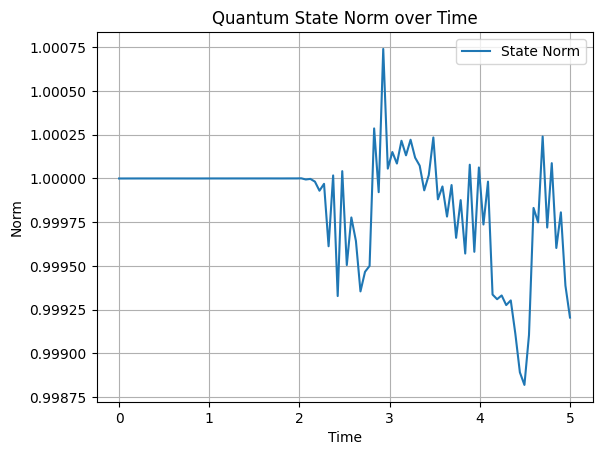

In [116]:
# Plot each of the additional metrics
plot_state_norm(time, psi_t)

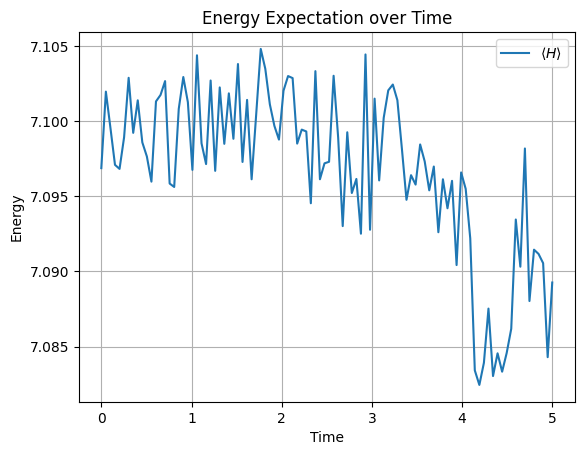

In [117]:
energy_expectation(time, psi_t, I_amplitude)

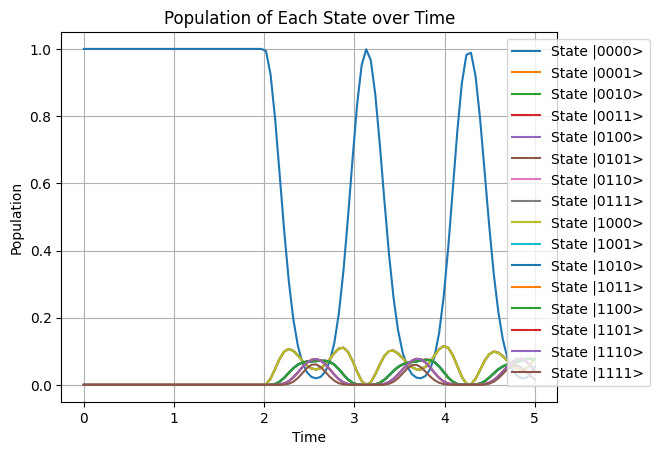

In [118]:
plot_population(time, psi_t)